# Abgabe Digitale Bildverarbeitung
Simon Ball

In diesem Notebook werden einige verschiedene Konzepte aufgegriffen, die ein Neuronales Netz mit den MNIST-Daten für handgeschriebene Ziffern trainineren. Parallel hierzu sind diese Konzepte in der PDF kurz dokumentiert.




### Imports

Im gesamten Dokument sind die Zeilen zu Weights and Biases auskommentiert, damit das Notebook auch ohne dieses Tool ausführbar ist. Außerdem wurde zum Speichern der Parameter Google Drive genutzt, was aus dem gleichen Grund auskommentiert ist.

In [1]:
import Augmentor
import datetime
import math
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.decomposition  import PCA
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, BatchNormalization, Activation, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

# Uncomment the following lines to use weights and biases
# import wandb
# from wandb.keras import WandbMetricsLogger

# Uncomment the following lines to mount Google Drive in Google Colab
# from google.colab import drive
# drive.mount('/content/drive')

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


### Daten laden, reduzieren und anzeigen

Hier werden die ersten 25 Bilder des Datensatzes ausgegeben, um einen Einblick in die Daten zu erhalten

x_train: (1000, 28, 28, 1)
y_train: (1000,)
x_test: (10000, 28, 28, 1)
y_test: (10000,)

 Plot of the first 25 samples in the MNIST training set


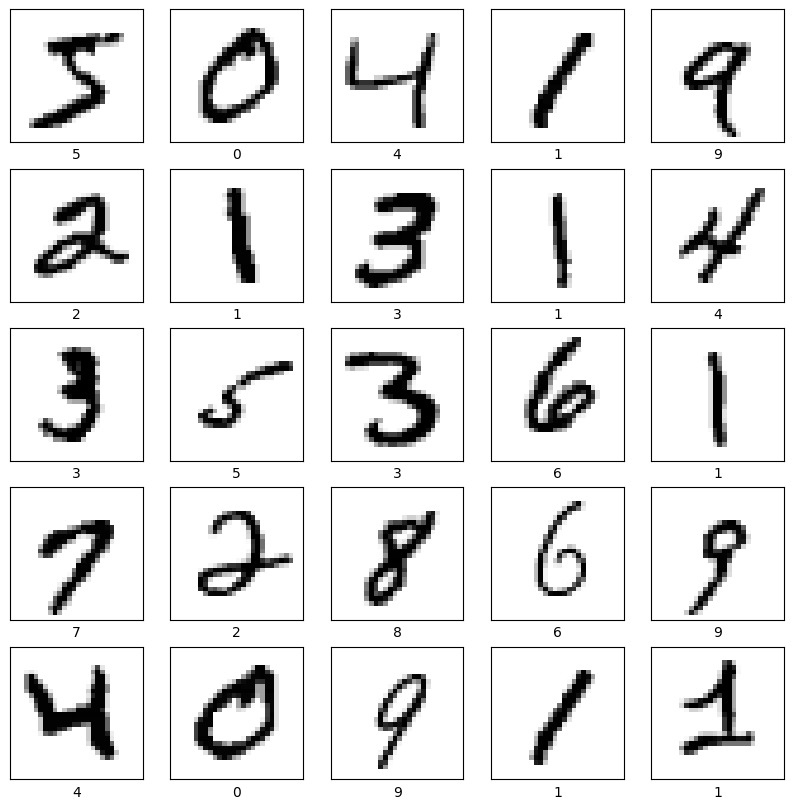

In [2]:
(x_train_entire, y_train_entire), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Reshape Data
x_train_entire = x_train_entire.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

# Reduce Data to 1000 Samples
x_train = x_train_entire[:1000]
y_train = y_train_entire[:1000]

# Printing the shape
print('x_train:', x_train.shape)
print('y_train:', y_train.shape)
print('x_test:', x_test.shape)
print('y_test:', y_test.shape)

# Plotting data samples
print('\n Plot of the first 25 samples in the MNIST training set')
numbers_to_display = 25
num_cells = math.ceil(math.sqrt(numbers_to_display))
plt.figure(figsize=(10,10))
for i in range(numbers_to_display):
    plt.subplot(num_cells, num_cells, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(y_train[i])
plt.show()

## 1. Data Augmentation

In diesem Bereich findet die Data Augmentation durch Rotation, Verzerrung und Zoom statt. Damit geprüft werden kann, dass die Daten nach dieser Veränderung noch lesbar sind, werden zehn Beispiele eines Samples jeder Ziffer ausgegeben.

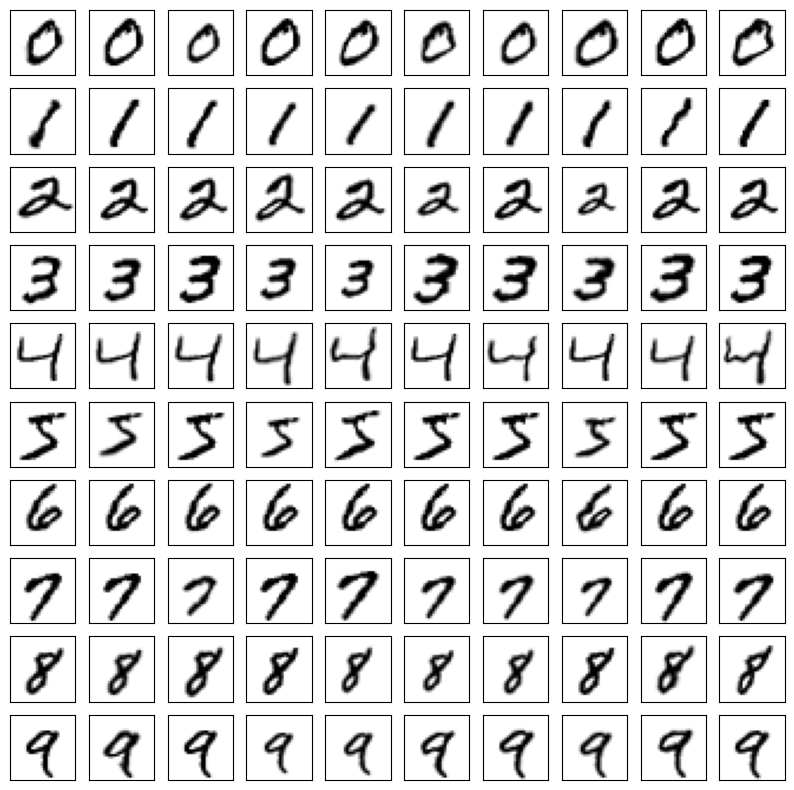

In [3]:
# Define the Pipeline
augmentor_pipeline = Augmentor.Pipeline()
augmentor_pipeline.rotate_without_crop(probability=0.2, max_left_rotation=5, max_right_rotation=5, fillcolor=0)
augmentor_pipeline.random_distortion(probability=0.2, grid_width=6, grid_height=6, magnitude=1)
augmentor_pipeline.zoom(probability=0.2, min_factor=0.8, max_factor=1.0)
augmentor_pipeline.skew(probability=0.2, magnitude=0.1)

# Plot ten augmentations of each digit
plt.figure(figsize=(10,10))
for digit in range(10):
  digit_index = np.where(y_train == digit)[0][0]
  image_generator = augmentor_pipeline.keras_generator_from_array(x_train[digit_index:digit_index+1], y_train[digit_index:digit_index+1], batch_size=10, scaled=True)
  x_train_aug, y_train_aug = next(image_generator)
  for number in range(10):
      plt.subplot(10, 10, digit*10 + number + 1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      plt.imshow(x_train_aug[number], cmap=plt.cm.binary)
plt.show()

# Generate the generator object for training
image_generator = augmentor_pipeline.keras_generator_from_array(x_train, y_train, batch_size=1024, scaled=True)

## 2. Convolutional Neural Network

Hier wird der erste Ansatz, ein Convolutional Neural Network getestet. Das ursprüngliche Netz stammt von https://www.kaggle.com/code/lakhindr/small-efficient-neural-network-for-mnist und wurde so angepasst, dass die Ansprüche mit den gegebenen Daten am besten erfüllt sind.

In [4]:
# Try to make the results repeatable
tf.keras.utils.set_random_seed(42)

# Prepare weights and biases / set parameters
# wandb.init(
#     project="CNN",
#     config={
#         "labels": 1000,
#         "epochs": 100
#     }
# )

# Define the model
model_conv = Sequential([
    Conv2D(filters=32, kernel_size=(5,5), strides=1, activation='relu', input_shape=(28, 28,1)),
    MaxPooling2D(pool_size=2, strides=2, padding='same'),
    Conv2D(filters=16, kernel_size=(5,5), strides=1, activation='relu'),
    MaxPooling2D(pool_size=2, strides=2, padding='same'),
    BatchNormalization(),
    Activation("relu"),
    Flatten(),
    Dense(units=64, activation='relu'),
    Dropout(rate=0.3),
    Dense(units=10, activation='softmax')
])

# Compile model
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
model_conv.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=loss_fn,
              metrics=['accuracy'])


# Define Callbacks
reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_accuracy",
    factor=0.2,
    patience=10,
    min_lr=0.0001
)
# checkpoint_filepath = f'./drive/MyDrive/MNIST/checkpoints/model_{datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}.h5' # Used for Google Drive
checkpoint_filepath = f'model_{datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# Train model
model_conv.fit(
    image_generator,
    steps_per_epoch=1,
    epochs=100, # wandb.config["epochs"],
    validation_data=(x_test, y_test),
    callbacks=[
        model_checkpoint_callback,
        reduce_lr_callback,
        # WandbMetricsLogger()
        ]
)

# Show model configuration
model_conv.summary()

# Evaluate best epoch and rename weights file
model = tf.keras.models.load_model(checkpoint_filepath)
results = model.evaluate(x_test, y_test)
print(f"test loss: {results[0]}, test acc: {results[1]}")
os.rename(checkpoint_filepath, f"{checkpoint_filepath[:-3]}_{results[1]:.4f}.h5")

# wandb.finish()

wandb: Currently logged in as: ballsimon (mnist_project). Use `wandb login --relogin` to force relogin


Epoch 1/100
1/1 [==============================] - 12s 12s/step - loss: 2.5239 - accuracy: 0.1055 - val_loss: 17.0109 - val_accuracy: 0.1649 - lr: 0.0010
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 2.3138 - accuracy: 0.1484

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 2s 2s/step - loss: 2.3138 - accuracy: 0.1484 - val_loss: 13.7698 - val_accuracy: 0.2053 - lr: 0.0010
Epoch 3/100
1/1 [==============================] - 3s 3s/step - loss: 2.1540 - accuracy: 0.2188 - val_loss: 11.7407 - val_accuracy: 0.2482 - lr: 0.0010
Epoch 4/100
1/1 [==============================] - 2s 2s/step - loss: 2.0467 - accuracy: 0.2441 - val_loss: 10.2557 - val_accuracy: 0.2973 - lr: 0.0010
Epoch 5/100
1/1 [==============================] - 3s 3s/step - loss: 1.9160 - accuracy: 0.3213 - val_loss: 9.3740 - val_accuracy: 0.3452 - lr: 0.0010
Epoch 6/100
1/1 [==============================] - 1s 1s/step - loss: 1.8485 - accuracy: 0.3730 - val_loss: 8.4161 - val_accuracy: 0.4022 - lr: 0.0010
Epoch 7/100
1/1 [==============================] - 1s 1s/step - loss: 1.7518 - accuracy: 0.4082 - val_loss: 7.5586 - val_accuracy: 0.4524 - lr: 0.0010
Epoch 8/100
1/1 [==============================] - 1s 1s/step - loss: 1.6943 - accuracy: 0.4746 - val_l

epoch/accuracy,▁▂▃▄▅▅▆▆▆▇▇▇▇▇▇▇█▇██████████████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch/learning_rate,█████████████████████████████████████▁▁▁
epoch/loss,█▇▆▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/lr,██████████████████████████████████████▁▁
epoch/val_accuracy,▁▂▃▄▅▆▆▆▆▇▇▇▇▇▇▇▇███████████████████████
epoch/val_loss,█▅▃▃▂▂▂▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,0.97754
epoch/epoch,99
epoch/learning_rate,0.0002
epoch/loss,0.09528


## 2.2 Monte Carlo Dropout

Diese Methode lässt die Dropout-Schichten auch beim Testen aktiviert, wodurch bei jedem Durchlauf der gleichen Testdaten unterschiedliche Ergebnisse herauskommen können. Dabei werden die Testdaten 100 mal nacheinander durch das Netz geschickt, wodurch bei Verrechnung ein genaueres Ergebnis erzielt werden kann.

Da der Arbeitsspeicher von Binder nicht ausreicht, um alle Vorhersagen zwischenzuspeichern, wurden diese Zeilen auskommentiert und nur die Ausgabezeile belassen.

In [5]:
# Predict test data 100 times and store probabilities
# y_probas = np.stack([model(x_test,training=True) for sample in range(100)])

# # Calculate mean of each digit and probability
# y_probas_mean = y_probas.mean(axis=0)

# # Get highes probability prediction for each sample
# y_pred = np.argmax(y_probas_mean,axis=1)

# # Calculate the accuracy of the model
# accuracy = sum(y_pred == y_test) / len(y_test)
# print(f"Test Accuracy: {accuracy}")

Test Accuracy: 0.9555


## 3. Neuronales Netz mit vorgeschaltener Principal Component Analysis (PCA)

Hier wird zunächst eine PCA auf alle 60000 Trainingsbilder angewendet, da dafür keine Labels benötigt werden. Die Dimension wird damit von 784 (28 x 28) auf 50 reduziert. Das nachfolgende Netz kann damit sehr klein gehalten werden.

In [6]:
# Flatten the data
x_train_entire_flattened = x_train_entire.reshape((x_train_entire.shape[0], -1))
x_train_flattened = x_train.reshape((x_train.shape[0], -1))
x_test_flattened = x_test.reshape((x_test.shape[0], -1))

# Execute the PCA
pca = PCA(n_components=50)
pca.fit(x_train_entire_flattened)
x_train_pca = pca.transform(x_train_flattened)
x_test_pca = pca.transform(x_test_flattened)

In [7]:
# Try to make the results repeatable
tf.keras.utils.set_random_seed(42)

# Prepare weights and biases / set parameters
# wandb.init(
#     project="PCA",
#     config={
#         "labels": 1000,
#         "epochs": 100
#     }
# )

# Define the model
model_pca = Sequential([
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])

# Compile model
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
model_pca.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss=loss_fn,
              metrics=['accuracy'])

# Define Callbacks
reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_accuracy",
    factor=0.2,
    patience=10,
    min_lr=0.0001
)
# checkpoint_filepath = f'./drive/MyDrive/MNIST/checkpoints/model_{datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}.h5' # Used for Google Drive
checkpoint_filepath = f'model_{datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# Train model
model_pca.fit(
    x_train_pca,
    y_train,
    batch_size=1024,
    steps_per_epoch=1,
    epochs=100, # wandb.config["epochs"],
    validation_data=(x_test_pca, y_test),
    callbacks=[
        model_checkpoint_callback,
        reduce_lr_callback,
        # WandbMetricsLogger()
        ]
)

# Show model configuration
model_pca.summary()

# Evaluate best epoch and rename weights file
model_pca = tf.keras.models.load_model(checkpoint_filepath)
results = model_pca.evaluate(x_test_pca, y_test)
print(f"test loss: {results[0]}, test acc: {results[1]}")
os.rename(checkpoint_filepath, f"{checkpoint_filepath[:-3]}_{results[1]:.4f}.h5")

# wandb.finish()

Epoch 1/100
1/1 [==============================] - 1s 1s/step - loss: 316.5688 - accuracy: 0.0730 - val_loss: 212.6331 - val_accuracy: 0.1315 - lr: 0.0100
Epoch 2/100
1/1 [==============================] - 0s 112ms/step - loss: 195.0087 - accuracy: 0.1290 - val_loss: 139.7835 - val_accuracy: 0.2374 - lr: 0.0100
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 111.3541 - accuracy: 0.2890

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 71ms/step - loss: 111.3541 - accuracy: 0.2890 - val_loss: 92.9140 - val_accuracy: 0.3853 - lr: 0.0100
Epoch 4/100
1/1 [==============================] - 0s 67ms/step - loss: 65.5041 - accuracy: 0.4950 - val_loss: 64.9512 - val_accuracy: 0.5274 - lr: 0.0100
Epoch 5/100
1/1 [==============================] - 0s 106ms/step - loss: 41.2878 - accuracy: 0.6500 - val_loss: 48.8640 - val_accuracy: 0.6260 - lr: 0.0100
Epoch 6/100
1/1 [==============================] - 0s 110ms/step - loss: 28.9039 - accuracy: 0.7490 - val_loss: 39.9922 - val_accuracy: 0.6888 - lr: 0.0100
Epoch 7/100
1/1 [==============================] - 0s 69ms/step - loss: 21.5068 - accuracy: 0.7990 - val_loss: 35.0595 - val_accuracy: 0.7309 - lr: 0.0100
Epoch 8/100
1/1 [==============================] - 0s 109ms/step - loss: 16.9895 - accuracy: 0.8340 - val_loss: 32.2593 - val_accuracy: 0.7565 - lr: 0.0100
Epoch 9/100
1/1 [==============================] - 0s 138ms/step - loss: 13.91

epoch/accuracy,▁▃▆▇▇▇▇█████████████████████████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch/learning_rate,███████████████▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/lr,████████████████▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▄▇▇████████████████████████████████████
epoch/val_loss,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,1.0
epoch/epoch,99
epoch/learning_rate,0.0001
epoch/loss,5e-05


## 4. Transfer Learning

Das letzte Konzept nutzt ein bereits trainiertes Netz (ResNet50), wodurch nur die Gewichte der letzten Schichten neu angepasst werden müssen. Da die Bilder für dieses Netz alllerdings drei Farbkanäle benötigen, müssen alle Bilder zunächst erweitert werden. Außerdem konnte die Bibliothek Augmentor wegen einem unverständlichen Fehler nicht genutzt werden, weshalb auf ImageDataGenerator zurückgegriffen wird.

Der Code wurde von https://www.hackersrealm.net/post/transfer-learning-using-pretrained-model-python angepasst.

Auch dieses Training kann aufgrund des fehlenden Arbeitsspeichers auf Binder nicht durchgeführt werden.

In [8]:
x_train_transfer = x_train.astype('float32')
x_test_transfer = x_test.astype('float32')

# convert data to 3 channels
x_train_transfer = np.repeat(x_train_transfer, repeats=3, axis=-1)
x_test_transfer = np.repeat(x_test_transfer, repeats=3, axis=-1)

# convert labels to be an array rather than a single number
y_train_transfer = to_categorical(y_train)
y_test_transfer = to_categorical(y_test)

# data augmentation with generator
train_generator = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 40,
    shear_range = 0.2,
    zoom_range = 0.2,
    fill_mode = 'nearest'
)
val_generator = ImageDataGenerator(rescale = 1./255)

# Create iterators
train_iterator = train_generator.flow(x_train_transfer, y_train_transfer, batch_size=512, shuffle=True)
val_iterator = val_generator.flow(x_test_transfer, y_test_transfer, batch_size=512, shuffle=False)


In [9]:
# Try to make the results repeatable
tf.keras.utils.set_random_seed(42)

# Prepare weights and biases / set parameters
# wandb.init(
#     project="ResNet",
#     config={
#         "labels": 1000,
#         "epochs": 100
#     }
# )

# Define the model with the pretrained weights
model_resnet = Sequential([
    ResNet50(include_top=False, pooling='avg', weights='imagenet'),
    Dense(512, activation='relu'),
    Dense(10, activation='softmax')
])

# set resnet layers to be not trainable
model_resnet.layers[0].trainable=False

# Compile model
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
model_resnet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=loss_fn,
              metrics=['accuracy'])

# Define Callbacks
reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_accuracy",
    factor=0.2,
    patience=10,
    min_lr=0.0001
)
# checkpoint_filepath = f'./drive/MyDrive/MNIST/checkpoints/model_{datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}.h5' # Used for Google Drive
checkpoint_filepath = f'model_{datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# Train model
model_resnet.fit(
    train_iterator,
    epochs = 100, # wandb.config["epochs"],
    validation_data=val_iterator,
    callbacks=[
        model_checkpoint_callback,
        reduce_lr_callback,
        # WandbMetricsLogger()
        ]
)

# Show model configuration
model_resnet.summary()

# Evaluate best epoch and rename weights file
model_resnet = tf.keras.models.load_model(checkpoint_filepath)
results = model_resnet.evaluate(val_iterator)
print(f"test loss: {results[0]}, test acc: {results[1]}")
os.rename(checkpoint_filepath, f"{checkpoint_filepath[:-3]}_{results[1]:.4f}.h5")

# wandb.finish()

Epoch 1/100
2/2 [==============================] - 13s 7s/step - loss: 2.6345 - accuracy: 0.1010 - val_loss: 2.3590 - val_accuracy: 0.2181 - lr: 0.0010
Epoch 2/100
2/2 [==============================] - 2s 1s/step - loss: 2.4321 - accuracy: 0.1820 - val_loss: 2.3663 - val_accuracy: 0.1639 - lr: 0.0010
Epoch 3/100
2/2 [==============================] - 2s 2s/step - loss: 2.3445 - accuracy: 0.2110 - val_loss: 2.1534 - val_accuracy: 0.3117 - lr: 0.0010
Epoch 4/100
2/2 [==============================] - 2s 2s/step - loss: 2.1813 - accuracy: 0.2800 - val_loss: 2.0412 - val_accuracy: 0.3157 - lr: 0.0010
Epoch 5/100
2/2 [==============================] - 2s 1s/step - loss: 2.0876 - accuracy: 0.2920 - val_loss: 1.9801 - val_accuracy: 0.2184 - lr: 0.0010
Epoch 6/100
2/2 [==============================] - 2s 1s/step - loss: 2.0571 - accuracy: 0.2060 - val_loss: 1.8970 - val_accuracy: 0.3071 - lr: 0.0010
Epoch 7/100
2/2 [==============================] - 2s 2s/step - loss: 1.9602 - accuracy: 0.33

epoch/accuracy,▁▂▂▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█▇████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch/learning_rate,████████████████████████████████████▁▁▁▁
epoch/loss,█▇▆▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch/lr,████████████████████████████████████▁▁▁▁
epoch/val_accuracy,▁▂▂▅▆▆▆▆▇▆▇▇▇▇▇▇▇▇█▇▇███████████████████
epoch/val_loss,█▇▆▆▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,0.752
epoch/epoch,99
epoch/learning_rate,0.0002
epoch/loss,0.82756
